In [ ]:
import os 
import urllib
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud 
import arabic_reshaper as ar
from bidi.algorithm import get_display
from IPython.display import display
import nltk
import io
import seaborn as sns
from textblob import TextBlob
from nltk.corpus import stopwords
%matplotlib inline
warnings.filterwarnings("ignore")

In [ ]:
#fetch the data
############################## Set-Variables ##############################
DATA_URLS=["https://alt.qcri.org/resources1/OSACT2022/OSACT2022-sharedTask-train.txt","https://alt.qcri.org/resources1/OSACT2022/OSACT2022-sharedTask-dev.txt"]
DATA_SETS_DIRECTORY="Data-sets"
DATA_NAME="sharedTask"
FIELS_NAMES=["OSACT2022-sharedTask-train.txt","OSACT2022-sharedTask-dev.txt"]
###########################################################################
DATA_PATH=os.path.join(DATA_SETS_DIRECTORY,DATA_NAME)
FIELS_PATHS=[os.path.join(DATA_PATH,file_name) for file_name in FIELS_NAMES]

def fetch_data(data_urls=DATA_URLS,data_path=DATA_PATH,files_paths=FIELS_PATHS):
    os.makedirs(data_path,exist_ok=True)
    for data_url,file_path in zip(data_urls,files_paths):
        urllib.request.urlretrieve(data_url, file_path)

#fetch_data()

In [ ]:
def load_data(files_paths=FIELS_PATHS):
    data=[]
    for file_path in files_paths :
        file=open(file_path,"r")
        content=file.read()   
        content=io.StringIO(content.replace(",","<,>").replace("\"","<\">")) 
        df=pd.read_csv(content,sep="\t",names=["id","tweet_text","OFF_label","HS_label","Vulgar_label","Violence_label"],encoding = 'utf8')
        df["tweet_text"]=df["tweet_text"].str.replace("<,>",",")
        df["tweet_text"]=df["tweet_text"].str.replace("<\">","\"")
        data.append(df)
    return data
data=load_data()

In [ ]:
labels=["OFF_label","HS_label","Vulgar_label","Violence_label"]
train_data=data[0]
dev_data=data[1]

In [ ]:
train_data.head()

,id,tweet_text,OFF_label,HS_label,Vulgar_label,Violence_label
0,1,@USER ردينا ع التطنز 😏👊🏻,OFF,NOT_HS,NOT_VLG,NOT_VIO
1,2,وصارت فطاير البقالات غذاء صحي 👎🏻 URL,NOT_OFF,NOT_HS,NOT_VLG,NOT_VIO
2,3,@USER روحي لبريده تلقين اشباه كثير بس ماحد زيك...,OFF,NOT_HS,NOT_VLG,NOT_VIO
3,4,@USER مش باين حاجه خالص 😣<LF>مش عارف بقى 😔,NOT_OFF,NOT_HS,NOT_VLG,NOT_VIO
4,5,#اليوم_الاثنين<LF><LF>👏 يقولك :%90 من المسلمي...,NOT_OFF,NOT_HS,NOT_VLG,NOT_VIO


In [ ]:
train_data.shape

(8887, 6)

In [ ]:
dev_data.shape

(1270, 6)

In [ ]:
train_data.head(10)

,id,tweet_text,OFF_label,HS_label,Vulgar_label,Violence_label
0,1,@USER ردينا ع التطنز 😏👊🏻,OFF,NOT_HS,NOT_VLG,NOT_VIO
1,2,وصارت فطاير البقالات غذاء صحي 👎🏻 URL,NOT_OFF,NOT_HS,NOT_VLG,NOT_VIO
2,3,@USER روحي لبريده تلقين اشباه كثير بس ماحد زيك...,OFF,NOT_HS,NOT_VLG,NOT_VIO
3,4,@USER مش باين حاجه خالص 😣<LF>مش عارف بقى 😔,NOT_OFF,NOT_HS,NOT_VLG,NOT_VIO
4,5,#اليوم_الاثنين<LF><LF>👏 يقولك :%90 من المسلمي...,NOT_OFF,NOT_HS,NOT_VLG,NOT_VIO
5,6,حمدلله ماحطها في فمي اساسا😷🤢 URL,NOT_OFF,NOT_HS,NOT_VLG,NOT_VIO
6,7,@USER هههه 😂🌚🤢,NOT_OFF,NOT_HS,NOT_VLG,NOT_VIO
7,8,#بايع_الكليجا اللي مايضحك من هالمقطع يبلكني هه...,NOT_OFF,NOT_HS,NOT_VLG,NOT_VIO
8,9,خلاص الله يزعجكم خلللاص 😷😷 #بايع_الكليجا,OFF,NOT_HS,NOT_VLG,NOT_VIO
9,10,@USER هيلق و جحلط غير كذا مافي 😷,OFF,NOT_HS,NOT_VLG,NOT_VIO


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8887 entries, 0 to 8886
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              8887 non-null   int64 
 1   tweet_text      8887 non-null   object
 2   OFF_label       8887 non-null   object
 3   HS_label        8887 non-null   object
 4   Vulgar_label    8887 non-null   object
 5   Violence_label  8887 non-null   object
dtypes: int64(1), object(5)
memory usage: 416.7+ KB


In [ ]:
train_data.describe()

,id
count,8887.000000
mean,4444.000000
std,2565.600255
min,1.000000
25%,2222.500000
50%,4444.000000
75%,6665.500000
max,8887.000000


In [ ]:
for label in labels:
    print("{} :".format(label))
    print("{}\n".format(train_data[label].value_counts()))

OFF_label :
NOT_OFF    5715
OFF        3172
Name: OFF_label, dtype: int64

HS_label :
NOT_HS    7928
HS6        456
HS1        260
HS3        144
HS5         72
HS2         27
Name: HS_label, dtype: int64

Vulgar_label :
NOT_VLG    8753
VLG         134
Name: Vulgar_label, dtype: int64

Violence_label :
NOT_VIO    8826
VIO          61
Name: Violence_label, dtype: int64



In [ ]:
for label in labels:
    print("{} :".format(label))
    print("{}\n".format(dev_data[label].value_counts()))

OFF_label :
NOT_OFF    866
OFF        404
Name: OFF_label, dtype: int64

HS_label :
NOT_HS    1161
HS6         52
HS1         28
HS3         14
HS5         10
HS2          4
HS4          1
Name: HS_label, dtype: int64

Vulgar_label :
NOT_VLG    1254
VLG          16
Name: Vulgar_label, dtype: int64

Violence_label :
NOT_VIO    1264
VIO           6
Name: Violence_label, dtype: int64



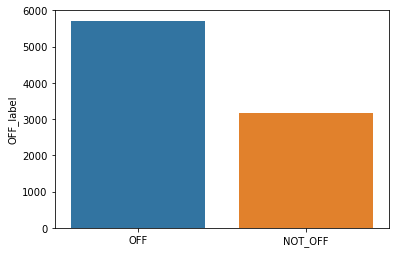

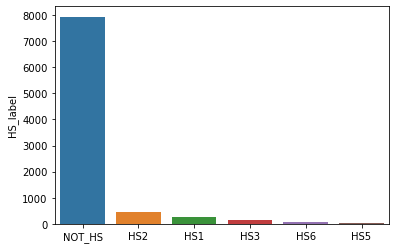

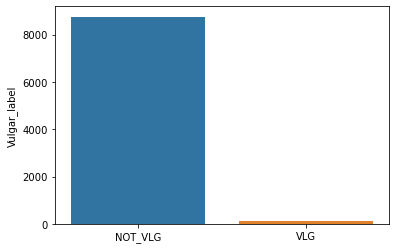

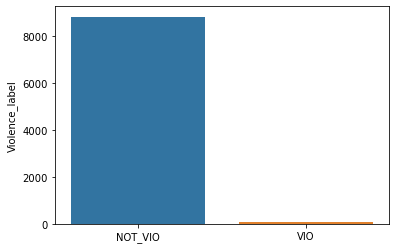

In [ ]:
for column in labels :
    classes=train_data[column].unique()
    sns.barplot(x=classes, y=train_data[column].value_counts())
    plt.show()

In [ ]:
# freq = pd.Series(' '.join(train_data["tweet_text"]).split()).value_counts()[:50]
# freq = list(freq.index)
# print(freq)

['@USER', 'من', 'URL', 'RT', 'الله', 'في', 'اللي', 'على', 'ما', 'و', 'بس', 'لا', 'انا', '😷', 'يا', 'ولا', 'والله', '#بايع_الكليجا', 'كل', 'ع', 'الي', '..', 'مع', 'مو', 'فيه', 'لو', 'وش', '😡', 'عن', 'شي', 'هذا', 'ان', '،', 'انت', 'البنات', 'هو', 'مش', 'بعد', 'اذا', 'ي', 'عشان', 'حتى', 'الناس', 'الا', '😤', 'يوم', 'كان', 'يعني', 'م', 'اي']


In [ ]:
#some light preprocessing to better visualize the text
train_data["tweet_text"]=train_data["tweet_text"].apply(lambda text:re.sub(' +', ' ', text))
train_data["tweet_text"]=train_data["tweet_text"].apply(lambda text:re.sub(r'[^0-9\u0600-\u06ff\u0750-\u077f\ufb50-\ufbc1\ufbd3-\ufd3f\ufd50-\ufd8f\ufd50-\ufd8f\ufe70-\ufefc\uFDF0-\uFDFD.0-9]+',' ', text))
freq = pd.Series(' '.join(train_data["tweet_text"]).split()).value_counts()[:100]
freq = list(freq.index)
print(freq)
train_data["tweet_text"] = train_data["tweet_text"].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

teet_stop_words=["و","مع","كان","لا","ما","على","يا","من"," في"]
stops.extend(stop_word_comp)
stops.extend(teet_stop_words)
stops=set(stops)

def remove_stop_words(text,stop_words_list):
    blob = TextBlob(text)
    words = blob.words
    return " ".join([word for word in words if not word in stops ])
train_data["tweet_text"]=train_data["tweet_text"].apply(lambda text:remove_stop_words(text,stops))

['من', 'الله', 'في', 'الكليجا', 'بايع', 'اللي', 'على', 'و', 'ما', 'بس', 'لا', 'انا', '.', 'والله', 'يا', 'ولا', '..', 'كل', 'ع', 'انت', 'الي', 'مع', 'فيه', 'هذا', 'مو', 'لو', 'وش', 'شي', '،', 'عن', 'ان', 'مش', 'هو', '؟', 'البنات', 'اذا', 'بعد', 'الا', 'ي', 'عشان', 'حتى', 'الناس', 'يعني', 'يوم', 'كان', 'م', 'اي', 'عليه', 'او', 'كذا', 'بالله', 'علي', 'الرجال', 'انتي', 'واحد', 'ف', 'ذا', 'غير', 'وانا', 'بعض', 'لما', 'لي', 'له', 'خلاص', 'بنات', 'عليك', 'ليش', 'وين', '...', 'ايه', 'كيف', 'انه', 'بنت', 'فيها', 'لك', 'اليوم', 'مره', 'عاد', 'عيب', 'اني', 'قال', 'ليه', 'صار', 'عادي', 'خير', 'كنت', 'لكن', 'قبل', 'صباح', 'مثل', 'ايش', 'هي', 'ناس', 'احد', 'هنا', 'وهو', 'لازم', 'ده', 'زي', 'طيب']


In [ ]:
train_data.head()

,id,tweet_text,OFF_label,HS_label,Vulgar_label,Violence_label
0,1,ردينا التطنز,OFF,NOT_HS,NOT_VLG,NOT_VIO
1,2,وصارت فطاير البقالات غذاء صحي,NOT_OFF,NOT_HS,NOT_VLG,NOT_VIO
2,3,روحي لبريده تلقين اشباه كثير ماحد زيكم مشفوح ي...,OFF,NOT_HS,NOT_VLG,NOT_VIO
3,4,باين حاجه خالص عارف بقى,NOT_OFF,NOT_HS,NOT_VLG,NOT_VIO
4,5,الاثنين يقولك 90 المسلمين عندهم خاله اسمها امل...,NOT_OFF,NOT_HS,NOT_VLG,NOT_VIO


In [ ]:
def wordCloud(data,column,target=None,target_val=None):      
    text=data[column].loc[data[target]==target_val].str.cat(sep=' ') if target else data[column].str.cat(sep=' ')
    text=ar.reshape(text)
    text=get_display(text)
    word_cloud=WordCloud(font_path='fonts/NotoNaskhArabic/NotoNaskhArabic-Regular.ttf',
                     max_font_size=120,
                     min_font_size=15,
                     max_words=500,
                     width=1000,
                     height=800,
                     margin=0,
                     colormap='Blues',
                     background_color='white'
                    ).generate(text)
    plt.figure(figsize = (10, 15))
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()

In [ ]:
def freq_ngram(corpus,freq=10,n=1):
    vec = CountVectorizer(ngram_range=(n, n))
    vec.fit(corpus)
    bow = vec.transform(corpus)
    count = bow.sum(axis=0) 
    words_freq = [(word, count[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    words_freq=pd.DataFrame(words_freq[:freq],columns=["text","frequency"])
    words_freq['text'] = words_freq["text"].apply(ar.reshape).apply(get_display)
    sns.barplot(y =words_freq['text'],x= words_freq["frequency"] )

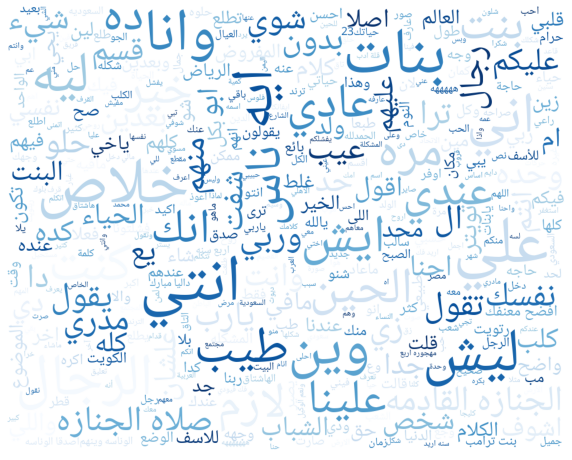

In [ ]:
wordCloud(train_data,"tweet_text")

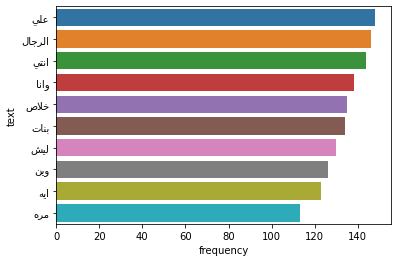

In [ ]:
freq_ngram(train_data["tweet_text"])

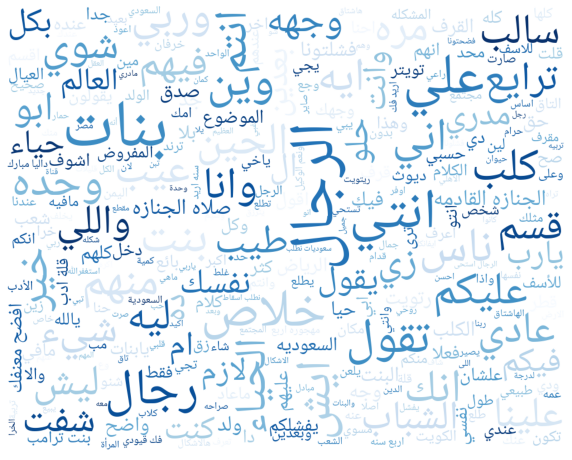

In [ ]:
wordCloud(train_data,"tweet_text","OFF_label","OFF")

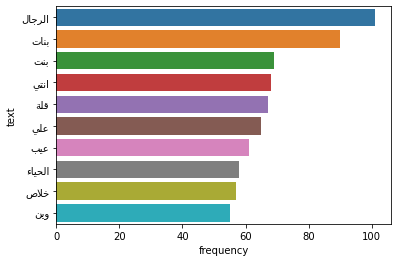

In [ ]:
freq_ngram(train_data.loc[train_data["OFF_label"]=="OFF"]["tweet_text"])

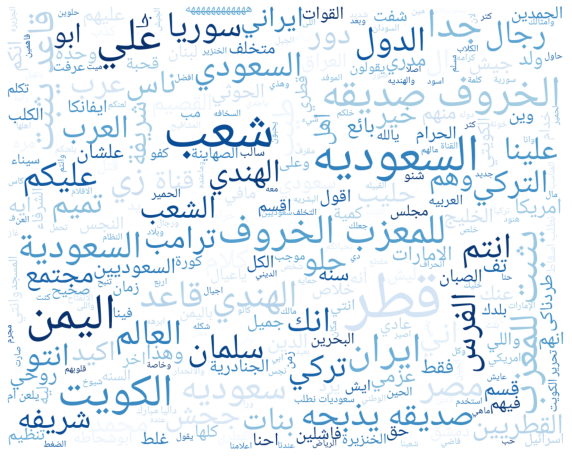

In [ ]:
wordCloud(train_data,"tweet_text","HS_label","HS1")

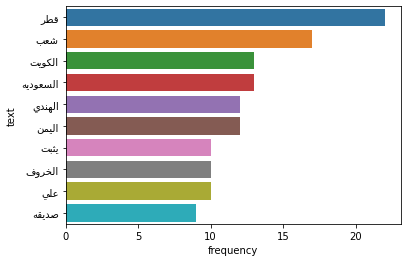

In [ ]:
freq_ngram(train_data.loc[train_data["HS_label"]=="HS1"]["tweet_text"])

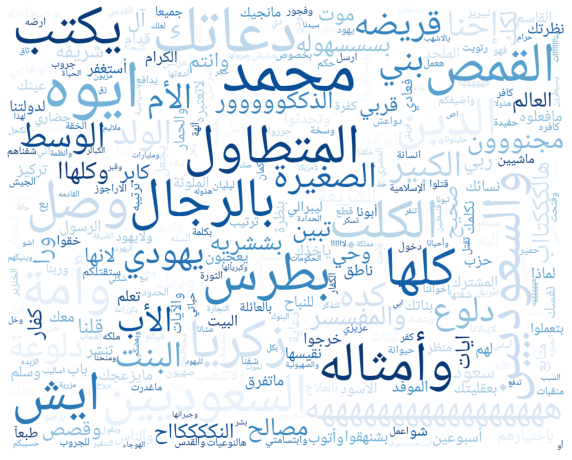

In [ ]:
wordCloud(train_data,"tweet_text","HS_label","HS2")

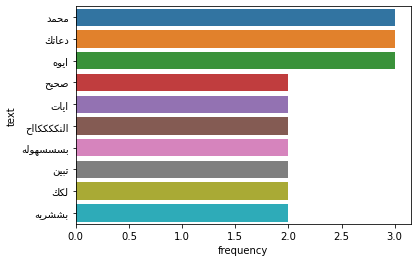

In [ ]:
freq_ngram(train_data.loc[train_data["HS_label"]=="HS2"]["tweet_text"])

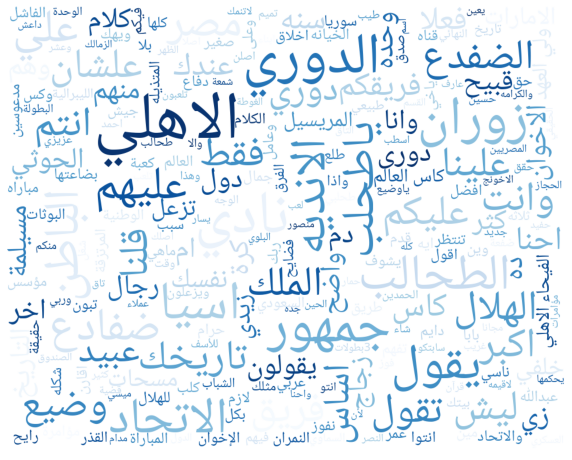

In [ ]:
wordCloud(train_data,"tweet_text","HS_label","HS3")

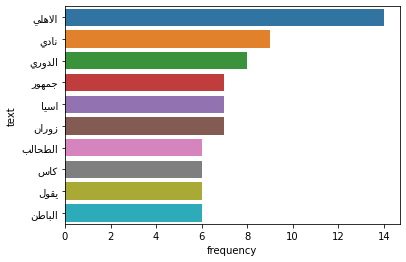

In [ ]:
freq_ngram(train_data.loc[train_data["HS_label"]=="HS3"]["tweet_text"])

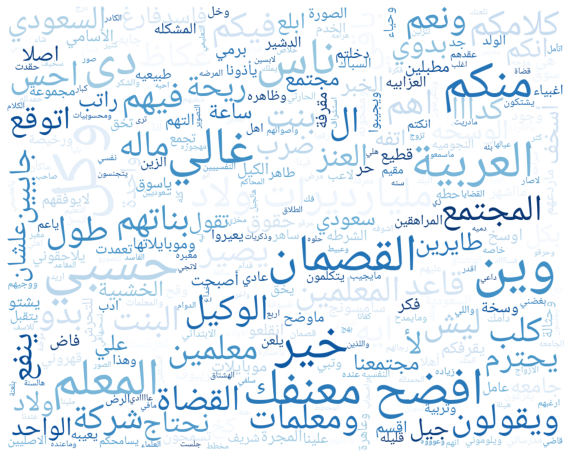

In [ ]:
wordCloud(train_data,"tweet_text","HS_label","HS5")

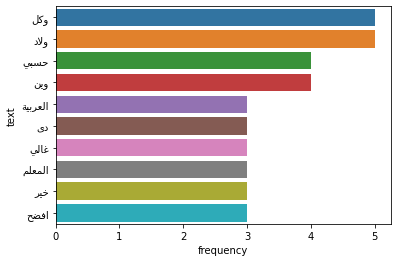

In [ ]:
freq_ngram(train_data.loc[train_data["HS_label"]=="HS5"]["tweet_text"])

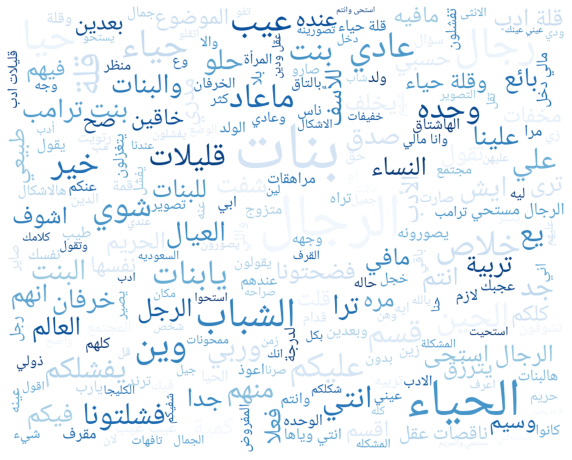

In [ ]:
wordCloud(train_data,"tweet_text","HS_label","HS6")

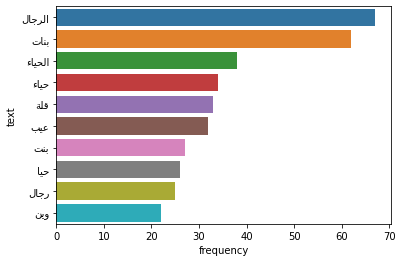

In [ ]:
freq_ngram(train_data.loc[train_data["HS_label"]=="HS6"]["tweet_text"])

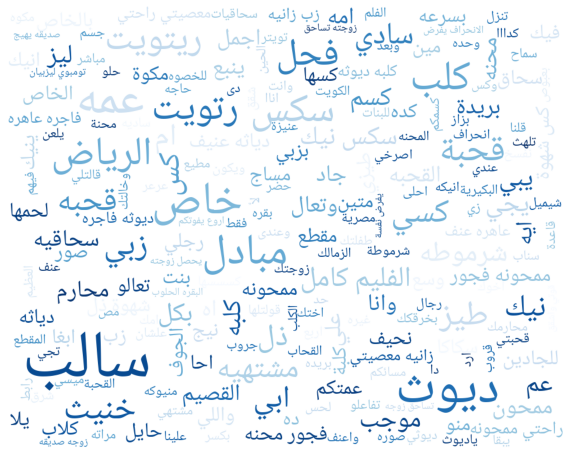

In [ ]:
wordCloud(train_data,"tweet_text","Vulgar_label","VLG")

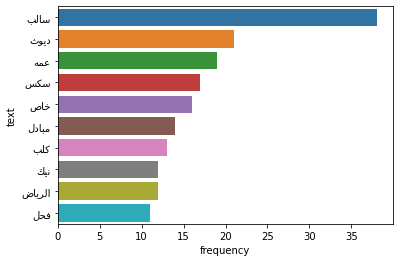

In [ ]:
freq_ngram(train_data.loc[train_data["Vulgar_label"]=="VLG"]["tweet_text"])

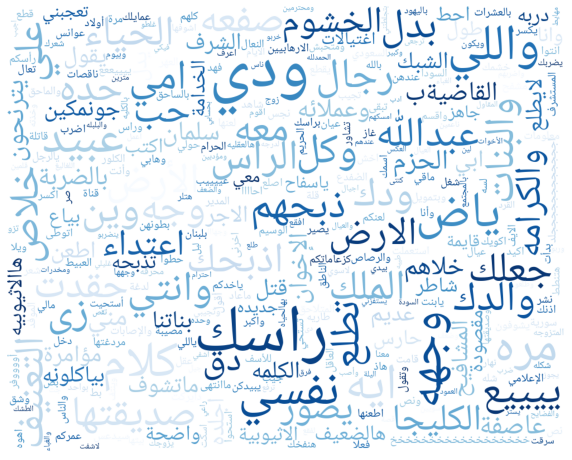

In [ ]:
wordCloud(train_data,"tweet_text","Violence_label","VIO")

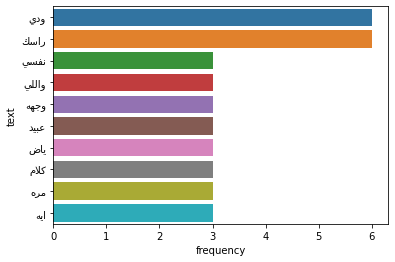

In [ ]:
freq_ngram(train_data.loc[train_data["Violence_label"]=="VIO"]["tweet_text"])